In [70]:
from yfinance import Ticker, download
import pandas as pd
import numpy as np
from scipy.stats import kendalltau, spearmanr
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.fft import fft, fftfreq, ifft
import numpy, scipy.optimize
import pylab as plt

## Loading Crypto Data and Extract df of Close prices

In [76]:
avail_cryptos = pd.read_excel("yf-crypto-tickers.xlsx").set_index("Unnamed: 0")["Tickers"]
df_close = pd.DataFrame()

for i in range(len(avail_cryptos)):
    df = Ticker(avail_cryptos[i]).history(period="1y")["Close"].rename(avail_cryptos[i])
    df_close = pd.concat([df_close, df], axis=1)
    
df_close = df_close.dropna(axis=1)

- BUSD2-USD: No data found, symbol may be delisted
- BUSD1-USD: No data found, symbol may be delisted
- EUR2-USD: No data found, symbol may be delisted
- TRY1-USD: No data found, symbol may be delisted


In [80]:
def get_crypto_df(ticker):
    df = Ticker(ticker).history(period="1y")["Close"].rename(ticker)
    return df

# Example of a lagged rolling correlation between BTC and ETH

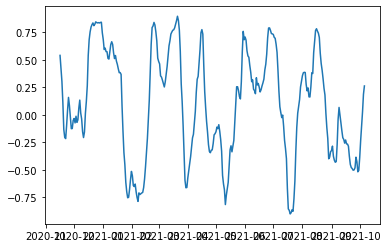

In [81]:
def lag_roll_corr(series1, series2, lag):
    """
    Inputs:
    - series1: series 1 who's current day values have their rolling correlation taken with series2's future lagged values - the hypothethical independent variable
    - series2: the series which has it's future values correlated with series1's past values - the hypothetical dependent variable
    Outputs:
    - lagged rolling correlation with series 1 current day values correlated with series 2 future lagged values
    """
    pair = pd.concat([series1, series2], axis=1)
    pair.iloc[:, 1] = pair.iloc[:, 1].shift(-lag)
    lagged_rcorr = pair.iloc[:, 0].rolling(lag).corr(pair.iloc[:, 1])
    lagged_rcorr = lagged_rcorr.dropna()
    return lagged_rcorr

def lag_roll_kendall(series1, series2, lag):
    """
    Inputs:
    - series1: series 1 who's current day values have their rolling kendall tau taken with series2's future lagged values - the hypothethical independent variable
    - series2: the series which has it's future values correlated with series1's past values - the hypothetical dependent variable
    Outputs:
    - lagged rolling correlation with series 1 current day values rank correlated (kendall tau) with series 2 future lagged values
    """
    ken_values = []
    series2 = series2.shift(-lag).dropna()
    
    for i in range(0, len(series2)-lag+1):
        ken_values.append(kendalltau(series1[0+i:lag+i], series2[0+i:lag+i])[0])

    return pd.DataFrame(ken_values).set_index(series1.index[lag-1:len(btc)-lag])

def lag_roll_spearman(series1, series2, lag):
    """
    Inputs:
    - series1: series 1 who's current day values have their rolling kendall tau taken with series2's future lagged values - the hypothethical independent variable
    - series2: the series which has it's future values correlated with series1's past values - the hypothetical dependent variable
    Outputs:
    - lagged rolling correlation with series 1 current day values rank correlated (spearman r) with series 2 future lagged values
    """
    ken_values = []
    series2 = series2.shift(-lag).dropna()
    
    for i in range(0, len(series2)-lag+1):
        ken_values.append(spearmanr(series1[0+i:lag+i], series2[0+i:lag+i])[0])

    return pd.DataFrame(ken_values).set_index(series1.index[lag-1:len(btc)-lag])


# example of how to run the functions
lag = 21
btc = df_close.iloc[:, 0]
eth = df_close.iloc[:, 1]
lag_rollktau = lag_roll_kendall(btc, eth, lag)
lag_roll_spearr = lag_roll_spearman(btc, eth, lag)
lag_roll_pears = lag_roll_corr(btc, eth, lag)

plt.plot(lag_roll_pears)

COTI-USD


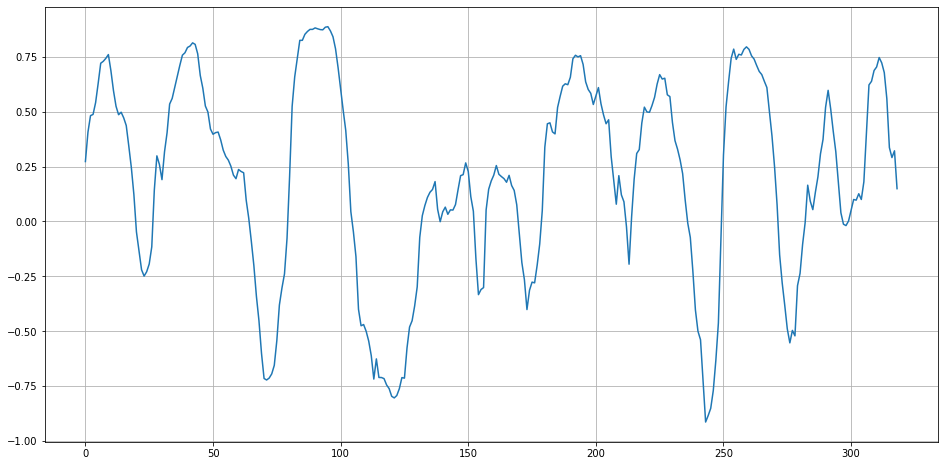

In [83]:
lag = 24
btc = df_close.iloc[:, 0]
dependent_var = df_close.iloc[:, 25]

print(dependent_var.name)

lag_roll_pears = lag_roll_corr(btc, dependent_var, lag)

plt.figure(figsize=(16,8))
plt.plot(np.arange(0, len(lag_roll_pears), 1), lag_roll_pears) # plotting lagged rolling pearson correlation
plt.grid()
plt.show()

# Fitting a sinewave to the data

In [84]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess, maxfev=5000)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

tt = np.arange(0, len(lag_roll_pears), 1)
res = fit_sin(tt, lag_roll_pears)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

Amplitude=-0.307658927265965, Angular freq.=0.11695394201767674, phase=-0.16782894093589018, offset=0.19688535261212947, Max. Cov.=0.04301181290046059


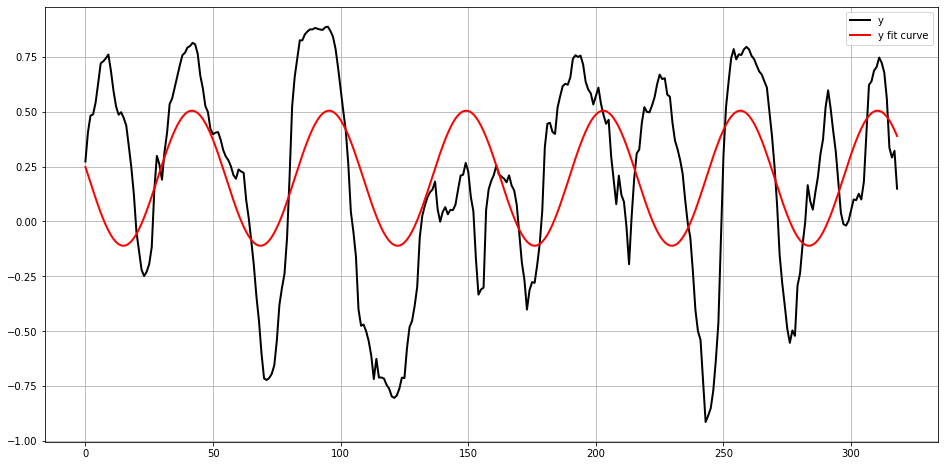

In [86]:
plt.figure(figsize=(16,8))
plt.plot(tt, lag_roll_pears, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

## Error Functions between Sine and Original

In [87]:
# MSE
mse = sum((lag_roll_pears.values - res["fitfunc"](tt))**2)

# MAE
mae = sum(abs(lag_roll_pears.values - res["fitfunc"](tt)))


## Putting it all together and finding the lags that correspond closest to a period sine wave

In [88]:
btc = df_close.iloc[:, 0]
dependent_var = df_close.iloc[:, 2]

output = []

for lag in range(2, 45):
    
    #print(lag)

    # obtaining the correlations
    lag_roll_pears = lag_roll_corr(btc, dependent_var, lag)

    # generating the sinewave
    tt = np.arange(0, len(lag_roll_pears), 1)
    res = fit_sin(tt, lag_roll_pears)

    # error functions
    mse = sum((lag_roll_pears.values - res["fitfunc"](tt))**2)
    mae = sum(abs(lag_roll_pears.values - res["fitfunc"](tt)))
    period = int((2*np.pi)/res["omega"])
    output.append([lag, mse, mae, period, btc.name, dependent_var.name])
    
display(output)

[[2, 350.43291869228756, 350.43291942286294, 5, 'BTC-USD', 'DOGE-USD'],
 [3, 176.19144886989957, 226.81817852519808, 5, 'BTC-USD', 'DOGE-USD'],
 [4, 141.69669466321955, 197.97796031667832, 20, 'BTC-USD', 'DOGE-USD'],
 [5, 106.76127444195998, 166.14857801674464, 17, 'BTC-USD', 'DOGE-USD'],
 [6, 94.13849244396613, 157.67514384486222, 39, 'BTC-USD', 'DOGE-USD'],
 [7, 89.84723111576429, 150.89047018290697, 38, 'BTC-USD', 'DOGE-USD'],
 [8, 88.77616550426112, 151.51279823344206, 68, 'BTC-USD', 'DOGE-USD'],
 [9, 72.7455734663044, 137.10645052003792, 70, 'BTC-USD', 'DOGE-USD'],
 [10, 68.98387646201896, 133.52672228260127, 37, 'BTC-USD', 'DOGE-USD'],
 [11, 70.92275044975922, 133.86244115435636, 37, 'BTC-USD', 'DOGE-USD'],
 [12, 67.35121865778574, 127.38913622919283, 304, 'BTC-USD', 'DOGE-USD'],
 [13, 69.08768888013199, 128.78554534684255, 297, 'BTC-USD', 'DOGE-USD'],
 [14, 73.68170137261626, 134.65963478448342, 37, 'BTC-USD', 'DOGE-USD'],
 [15, 63.14953319584752, 123.02448870981182, 37, 'BTC-US

### Getting IDX of minimum MSEs or MAEs

In [89]:
mses = pd.DataFrame(output)[1].values
maes = pd.DataFrame(output)[2].values

k = 3

top_lags = pd.DataFrame(output)
columns = ["Lags", "MSE", "MAE", "Periodicity", "Independent Var", "Dependent Var"]
top_lags.columns = columns
top_lags = top_lags[top_lags["Periodicity"] < 100] # periodicity filter
top_lags.nsmallest(k, "MSE")

,Lags,MSE,MAE,Periodicity,Independent Var,Dependent Var
19,21,46.130605,103.604574,33,BTC-USD,DOGE-USD
20,22,46.983190,103.925852,33,BTC-USD,DOGE-USD
39,41,48.996889,98.759745,91,BTC-USD,DOGE-USD


In [90]:
mses = pd.DataFrame(output)[1].values
maes = pd.DataFrame(output)[2].values

k = 3

top_lags = pd.DataFrame(output)
columns = ["Lags", "MSE", "MAE", "Periodicity", "Independent Var", "Dependent Var"]
top_lags.columns = columns

display(top_lags)
top_lags = top_lags[top_lags["Periodicity"] < 100] # periodicity filter

idx = np.argpartition(top_lags["MSE"].values, k) # getting best fits 

top_lags = top_lags.loc[idx[:k]] # keeping top 'k' optimal fits

top_lags

,Lags,MSE,MAE,Periodicity,Independent Var,Dependent Var
0,2,350.432919,350.432919,5,BTC-USD,DOGE-USD
1,3,176.191449,226.818179,5,BTC-USD,DOGE-USD
2,4,141.696695,197.977960,20,BTC-USD,DOGE-USD
3,5,106.761274,166.148578,17,BTC-USD,DOGE-USD
4,6,94.138492,157.675144,39,BTC-USD,DOGE-USD
5,7,89.847231,150.890470,38,BTC-USD,DOGE-USD
6,8,88.776166,151.512798,68,BTC-USD,DOGE-USD
7,9,72.745573,137.106451,70,BTC-USD,DOGE-USD
8,10,68.983876,133.526722,37,BTC-USD,DOGE-USD
9,11,70.922750,133.862441,37,BTC-USD,DOGE-USD


,Lags,MSE,MAE,Periodicity,Independent Var,Dependent Var
17,19,62.585047,122.648553,55,BTC-USD,DOGE-USD
18,20,55.155321,112.524632,33,BTC-USD,DOGE-USD
19,21,46.130605,103.604574,33,BTC-USD,DOGE-USD


# Hypothesis Testing - Finding the optimal lags and assets that Bitcoin and Ethereum periodically predict

### Function to return top lags

In [91]:
def return_top_lags(predictor, predictee, k):

    output = []

    for lag in range(2, 45):

        #print(lag)

        # obtaining the correlations
        lag_roll_pears = lag_roll_corr(predictor, predictee, lag)

        # generating the sinewave
        tt = np.arange(0, len(lag_roll_pears), 1)
        res = fit_sin(tt, lag_roll_pears)

        # error functions
        mse = sum((lag_roll_pears.values - res["fitfunc"](tt))**2)
        mae = sum(abs(lag_roll_pears.values - res["fitfunc"](tt)))
        period = int((2*np.pi)/res["omega"])
        output.append([lag, mse, mae, period, predictor.name, predictee.name])
        
        
    mses = pd.DataFrame(output)[1].values # getting MSEs in df

    top_lags = pd.DataFrame(output) # put all values into dataframe

    columns = ["Lags", "MSE", "MAE", "Periodicity", "Independent Var", "Dependent Var"] # column names
    
    top_lags.columns = columns # set col names

    top_lags = top_lags[top_lags["Periodicity"] < 100] # periodicity filter

    top_lags = top_lags.nsmallest(k, "MSE")
    
    return top_lags

# Experiment 1: Running function with BTC and ETH as predictors and finding most periodic correlations

In [111]:
k = 3

per_hy_df = pd.DataFrame()

for j in range(0, 2):

    predictor = df_close.iloc[:, j] 
    
    for i in range(1, len(df_close.columns)-1):
        dependent_var = df_close.iloc[:, i]
        tmp_df = return_top_lags(predictor, dependent_var, k)
        per_hy_df = pd.concat([per_hy_df, tmp_df], axis=0)
    
per_hy_df = per_hy_df.sort_values(by="MSE")

per_hy_df = per_hy_df.reset_index(drop=True)

per_hy_df

,Lags,MSE,MAE,Periodicity,Independent Var,Dependent Var
0,34,10.048339,43.817791,51,BTC-USD,USDT-USD
1,33,10.122240,43.297376,87,BTC-USD,USDT-USD
2,32,10.668008,43.399297,86,BTC-USD,USDT-USD
3,44,10.994317,46.973347,60,ETH-USD,USDT-USD
4,32,11.971476,50.378917,52,ETH-USD,USDT-USD
...,...,...,...,...,...,...
157,18,63.118426,119.569467,37,ETH-USD,VET-USD
158,20,63.507135,120.991609,37,ETH-USD,VET-USD
159,8,69.693673,131.648181,27,ETH-USD,THETA-USD
160,16,72.977659,132.317877,46,ETH-USD,THETA-USD


### Plotting the most period lagged correlation

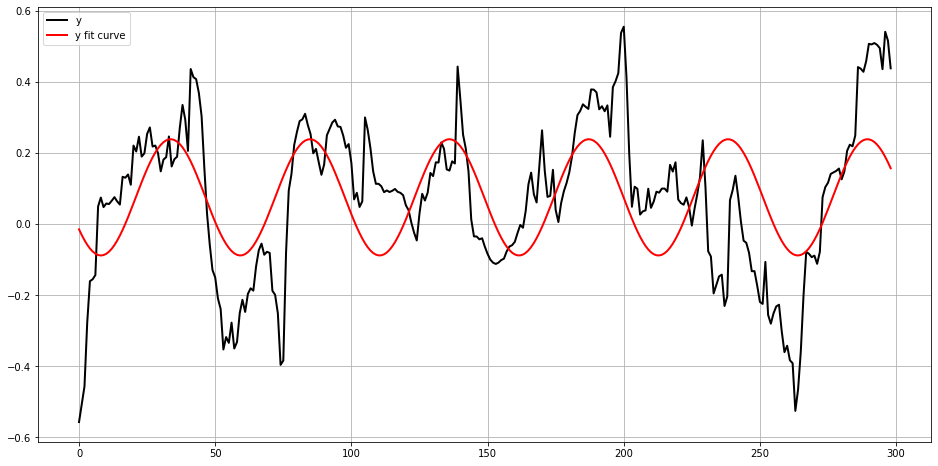

Independent Variable:  BTC-USD - Dependent Variable:  USDT-USD


In [133]:
lags = per_hy_df.iloc[0]["Lags"]

indep = df_close[per_hy_df.iloc[0]["Independent Var"]]

dep = df_close[per_hy_df.iloc[0]["Dependent Var"]]

lag_roll_pears = lag_roll_corr(indep, dep, lags)

# generating the sinewave
tt = np.arange(0, len(lag_roll_pears), 1)
res = fit_sin(tt, lag_roll_pears)

plt.figure(figsize=(16,8))
plt.plot(tt, lag_roll_pears, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

print("Independent Variable: ", per_hy_df.iloc[0]["Independent Var"], "-", "Dependent Variable: ", per_hy_df.iloc[0]["Dependent Var"])

### Function to return assets with largest % of lagged correlations greater than threshold value

In [129]:
def return_top_perc(predictor, predictee, k, thresh):
    
    output = []
    
    for lag in range(2, 45):
        lag_roll_pears = lag_roll_corr(predictor, predictee, lag)
        perc = len(lag_roll_pears[abs(lag_roll_pears) > thresh])/len(lag_roll_pears)
        
        output.append([lag, perc, predictor.name, predictee.name])
        
    top_perc = pd.DataFrame(output)
    
    columns = ["Lags", "Percentage > {}".format(thresh), "Independent Var", "Dependent Var"] # column names
    
    top_perc.columns = columns # set col names
    
    top_perc = top_perc.nsmallest(k, "Percentage > {}".format(thresh))
                                  
    return top_perc

# Experiment 2: Finding lagged correlations with greatest % of values > threshold

In [131]:
thresh = 0.7
k = 3

high_corr = pd.DataFrame()

for j in range(0, 2):

    predictor = df_close.iloc[:, j] 
    
    for i in range(2, len(df_close.columns)-1):
        dependent_var = df_close.iloc[:, i]
        tmp_df = return_top_perc(predictor, dependent_var, k, thresh)
        high_corr = pd.concat([high_corr, tmp_df], axis=0)
        
high_corr = high_corr.sort_values(by= "Percentage > {}".format(thresh), ascending=False)

high_corr = high_corr.reset_index(drop=True)

high_corr

,Lags,Percentage > 0.7,Independent Var,Dependent Var
0,24,0.191223,ETH-USD,LUNA1-USD
1,12,0.189504,ETH-USD,SOL1-USD
2,37,0.184300,ETH-USD,SOL1-USD
3,29,0.181230,ETH-USD,LUNA1-USD
4,26,0.180952,ETH-USD,EGLD-USD
...,...,...,...,...
151,20,0.000000,BTC-USD,USDT-USD
152,19,0.000000,BTC-USD,USDT-USD
153,17,0.000000,BTC-USD,USDT-USD
154,27,0.000000,ETH-USD,USDT-USD


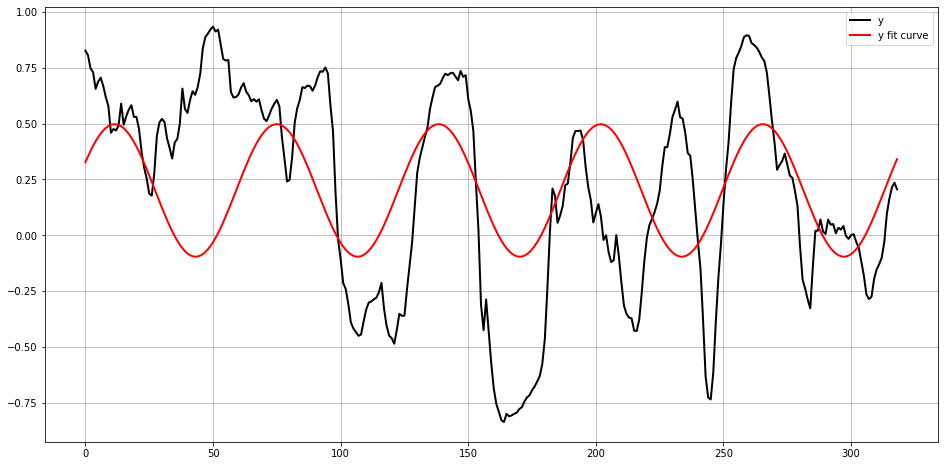

Independent Variable:  ETH-USD - Dependent Variable:  LUNA1-USD


In [134]:
lags = high_corr.iloc[0]["Lags"]

indep = df_close[high_corr.iloc[0]["Independent Var"]]

dep = df_close[high_corr.iloc[0]["Dependent Var"]]

lag_roll_pears = lag_roll_corr(indep, dep, lags)

# generating the sinewave
tt = np.arange(0, len(lag_roll_pears), 1)
res = fit_sin(tt, lag_roll_pears)

plt.figure(figsize=(16,8))
plt.plot(tt, lag_roll_pears, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

print("Independent Variable: ", high_corr.iloc[0]["Independent Var"], "-", "Dependent Variable: ", high_corr.iloc[0]["Dependent Var"])

# Experiment 3: Finding the most accurate directional lagged correlations predicted by sinusoids
- take sign of differenced of the lagged correlations
- take sign of difference of fitted sine waves
- obtain percentage of correctly predicted values

### Plotting the optimal periodic lags

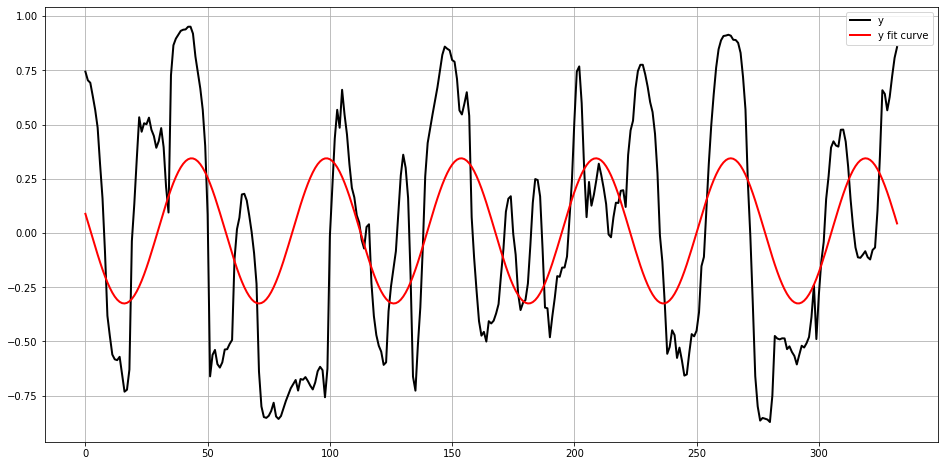

In [206]:
# check the lag plot
lag = idx[0]
btc = df_close.iloc[:, 0]
dependent_var = df_close.iloc[:, 2]

lag_roll_pears = lag_roll_corr(btc, dependent_var, lag)

# generating the sinewave
tt = np.arange(0, len(lag_roll_pears), 1)
res = fit_sin(tt, lag_roll_pears)

plt.figure(figsize=(16,8))
plt.plot(tt, lag_roll_pears, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

### Periodicity of Sine

In [207]:
period = (2*np.pi)/res["omega"]

print("Periodicity of Sine is: ", int(np.round(period)), " Days.")

Periodicity of Sine is:  55  Days.


# Fitting 2 Sinewaves to data?

In [21]:
import numpy, scipy.optimize
import pylab as plt
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])
    guess = np.append(guess, guess)

    def doublesinfunc(t, A, w, p, c, A2, w2, p2, c2):  return (A * numpy.sin(w*t + p) + c) + (A2 * numpy.sin(w2*t + p2) + c2)
    popt, pcov = scipy.optimize.curve_fit(doublesinfunc, tt, yy, p0=guess)
    A, w, p, c, A2, w2, p2, c2 = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: (A * numpy.sin(w*t + p) + c) + (A2 * numpy.sin(w2*t + p2) + c2)
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

tt = np.arange(0, len(lag_roll_pears), 1)
yy = lag_roll_pears
res = fit_sin(tt, yy)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

Amplitude=0.2493381269269311, Angular freq.=0.14896957507734185, phase=6.739315075053622, offset=-4.590125508090971, Max. Cov.=1705269590251.6182


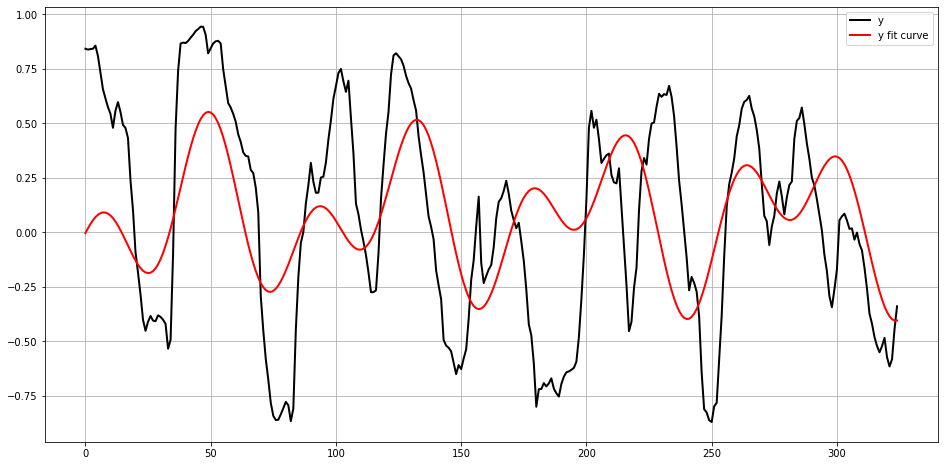

In [22]:
plt.figure(figsize=(16,8))
plt.plot(tt, yy, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

## Attempting to Analyse Power Spectral Density of Lagged Correlations (looking for harmonic frequencies - recurring correlation patterns)

- Plot Autocorrelation
- Plot normalised power spectral density

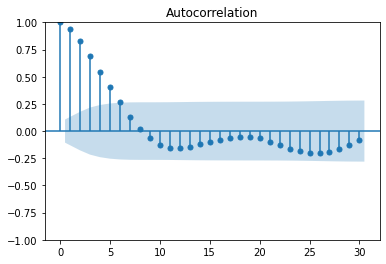

In [159]:
autocorr = []

for i in range(1, 160):
    shifted = lag_roll_pears.shift(i).dropna()
    autocorr.append(np.corrcoef(shifted, lag_roll_pears[-len(shifted):])[0][1])
    
plot_acf(lag_roll_pears, lags=30)
plt.show()

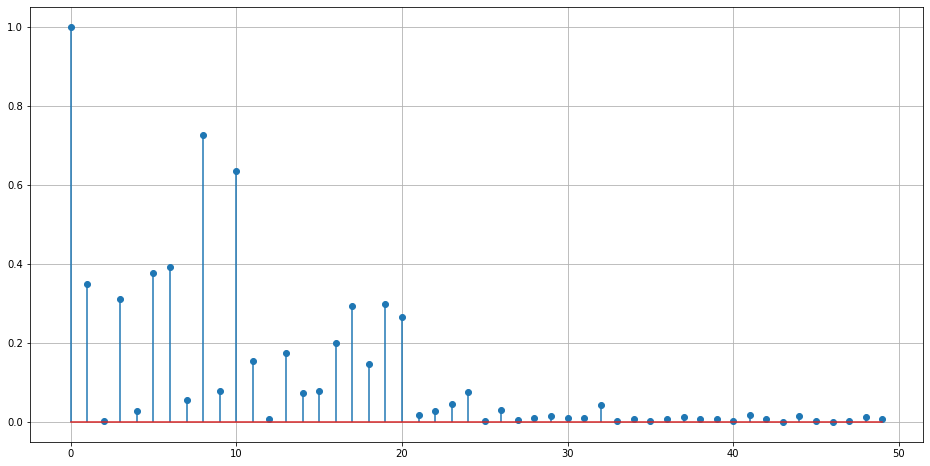

In [158]:
f = fft((np.array(lag_roll_pears)))
frq = f*np.conj(f)
norm_frq = np.abs(frq)/np.max(np.abs(frq))

plt.figure(figsize=(16, 8))
plt.stem(norm_frq[:50])
plt.grid()

In [144]:
ACF = acf(lag_roll_pears) # ACF
PSD = fft(ACF) # PSD

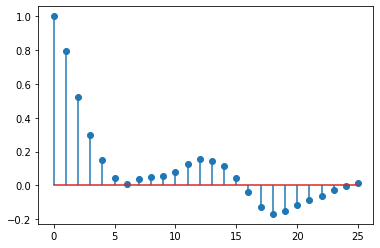

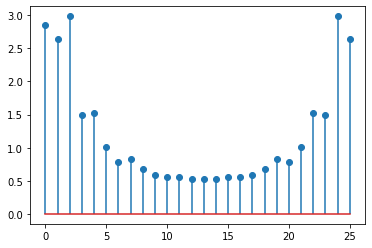

In [145]:
plt.stem(ACF)
plt.show()
plt.stem(np.abs(PSD))
plt.show()

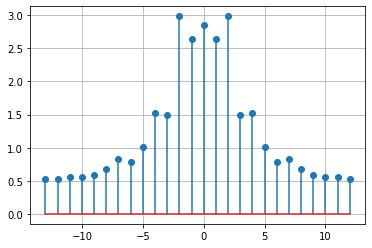

In [146]:
q = np.abs(PSD[0:13])
p = np.abs(PSD[13:])
x = np.arange(-len(PSD)/2 , len(PSD)/2  , 1)
plt.stem(x, np.append(p, q))
plt.grid()